In [31]:
# .................................................................
# PSO con restricciones
#      maximizar utilidad    375*A + 275*B + 475*C + 325*D
#
#      sujeto a:
#                     2.5*A + 1.5*B + 2.75*C + 2*D  <= 640
#                     3.5*A + 3*B   + 3*C    + 2*D  <= 960
# A, B, C, D >= 0. 
# Están expresado en base 100 unidades.
# .................................................................
import numpy as np

In [32]:
# función objetivo a maximizar
def f(x):
    return 375*x[0] + 275*x[1] + 475*x[2] + 325*x[3] # funcion objetivo: 375*A + 275*B + 475*C + 325*D


# primera restriccion
def g1(x):
    return 2.5*x[0] + 1.5*x[1] + 2.75*x[2] + 2*x[3] - 640 <= 0  # restriccion: 2.5*A + 1.5*B + 2.75*C + 2*D  <= 640


# segunda restriccion
def g2(x):
    return 3.5*x[0] + 3*x[1]   + 3*x[2]    + 2*x[3] - 960 <= 0  # restriccion: 3.5*A + 3*B   + 3*C    + 2*D  <= 960

# no negatividad
def g3(x):
    return x[0] >=0 and x[1] >=0 and x[2] >=0 and x[3] >=0



In [33]:
def correr(n_particles, n_dimensions, max_iterations, c1, c2, inercia='coef', w=0.6, fi=None):

    """
    Función para optimizar usando PSO con restricciones
    Se deben dar los parámetros
    n_particles: numero de partículas
    n_dimensions: cantidad de dimensiones
    max_iterations
    c1, c2: coeficientes cognitivo y social
    inercia: metodo de inercia a utilizar:
        - mediante coeficiente w fijo: Puede proveerse w, sino por defecto será 0.6
        - dinamico
        - con factor de contstricción: opcional se proveerá fi, sino se calcula como c1+c2
    """

    # inicialización de particulas
    x = np.zeros((n_particles, n_dimensions))  # matriz para las posiciones de las particulas
    v = np.zeros((n_particles, n_dimensions))  # matriz para las velocidades de las particulas
    pbest = np.zeros((n_particles, n_dimensions))  # matriz para los mejores valores personales
    pbest_fit = -np.inf * np.ones(n_particles)  # vector para las mejores aptitudes personales (inicialmente -infinito)
    gbest = np.zeros(n_dimensions)  # mejor solución global
    gbest_fit = -np.inf  # mejor aptitud global (inicialmente -infinito)

    # inicializacion de particulas factibles
    for i in range(n_particles):
        while True:  # bucle para asegurar que la particula sea factible
            x[i] = np.random.uniform(0, 10, n_dimensions)  # inicializacion posicion aleatoria en el rango [0, 10]
            if g1(x[i]) and g2(x[i]) and g3(x[i]):  # se comprueba si la posicion cumple las restricciones
                break  # Salir del bucle si es factible
        v[i] = np.random.uniform(-1, 1, n_dimensions)  # inicializar velocidad aleatoria
        pbest[i] = x[i].copy()  # ee establece el mejor valor personal inicial como la posicion actual
        fit = f(x[i])  # calculo la aptitud de la posicion inicial
        if fit > pbest_fit[i]:  # si la aptitud es mejor que la mejor conocida
            pbest_fit[i] = fit  # se actualiza el mejor valor personal

    # Optimizacion
    registro = np.empty([max_iterations,n_dimensions+1])
    for iteracion in range(max_iterations):  # Repetir hasta el número máximo de iteraciones
        # definicion de w dependiento del metodo de inercia
        if inercia == 'din':
                wmin =0.4
                wmax = 0.9
                w = wmax - (wmax - wmin)*iteracion/max_iterations                
        elif inercia == 'coef':
             w = w
        elif inercia == 'fc':
             w = None
             if fi == None: fi = c1 + c2
            
        # print(iteracion,w)
                
        for i in range(n_particles):
            fit = f(x[i])  # Se calcula la aptitud de la posicion actual
            # Se comprueba si la nueva aptitud es mejor y si cumple las restricciones
            if fit > pbest_fit[i] and g1(x[i]) and g2(x[i]) and g3(x[i]):
                pbest_fit[i] = fit  # Se actualiza la mejor aptitud personal
                pbest[i] = x[i].copy()  # Se actualizar la mejor posicion personal
                if fit > gbest_fit:  # Si la nueva aptitud es mejor que la mejor global
                    gbest_fit = fit  # Se actualizar la mejor aptitud global
                    gbest = x[i].copy()  # Se actualizar la mejor posicion global

            # actualizacion de la velocidad de la particula dependiento el metodo de inercia
            if inercia == 'fc':                 
                 fc = 2/np.abs(2 - fi - np.sqrt(np.abs(fi**2 - 4*fi)))
                 v[i] = fc * (v[i] + c1 * np.random.rand() * (pbest[i] - x[i]) + c2 * np.random.rand() * (gbest - x[i]))
            else:
                 v[i] = w * v[i] + c1 * np.random.rand() * (pbest[i] - x[i]) + c2 * np.random.rand() * (gbest - x[i])

            x[i] += v[i]  # Se actualiza la posicion de la particula

            # se asegura de que la nueva posicion esté dentro de las restricciones
            if not (g1(x[i]) and g2(x[i]) and g3(x[i])):
                # Si la nueva posicion no es válida, revertir a la mejor posicion personal
                x[i] = pbest[i].copy()
        
        registro[iteracion,:-1] = gbest
        registro[iteracion,-1] = gbest_fit
        # print(f'iteración: {_}')
        # print(f"Mejor solucion: [{gbest[0]:.4f}, {gbest[1]:.4f},{gbest[2]:.4f}, {gbest[3]:.4f}]")
        # print(f"Valor optimo: {gbest_fit:.1f}")

    # Se imprime la mejor solucion encontrada y también su valor optimo
    # print(f"Mejor solucion: [{gbest[0]:.4f}, {gbest[1]:.4f},{gbest[2]:.4f}, {gbest[3]:.4f}]")
    # print(f"Valor optimo: {gbest_fit:.1f}")
    return registro

In [34]:
# parametros
n_particles = 6  # numero de particulas en el enjambre
n_dimensions = 4  # dimensiones del espacio de busqueda (A, B, C, D)
max_iterations = 50  # numero máximo de iteraciones para la optimizacion
c1 = c2 = 1.4944  # coeficientes de aceleracion
w = 0.6  # Factor de inercia

In [35]:
registro = correr(n_particles, n_dimensions, max_iterations, c1, c2, inercia='coef', w=w)
gbest = registro[-1,:-1]
gbest_fit = registro[-1,-1]
print(f"Mejor solucion: [{gbest[0]:.4f}, {gbest[1]:.4f},{gbest[2]:.4f}, {gbest[3]:.4f}]")
print(f"Valor optimo: {gbest_fit:.1f}")

Mejor solucion: [83.8954, 31.1148,89.4518, 68.7984]
Valor optimo: 104866.4


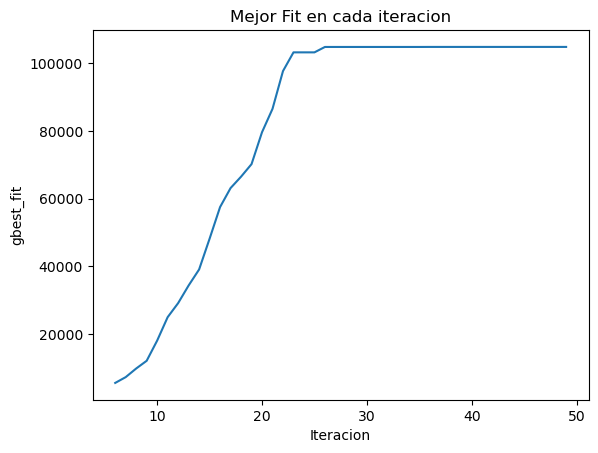

In [36]:
# inciso d
import matplotlib.pyplot as plt
plt.plot(registro[:,-1])

plt.title('Mejor Fit en cada iteracion')
plt.xlabel("Iteracion")
plt.ylabel("gbest_fit")
# plt.legend()
plt.show()

d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\cv1\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


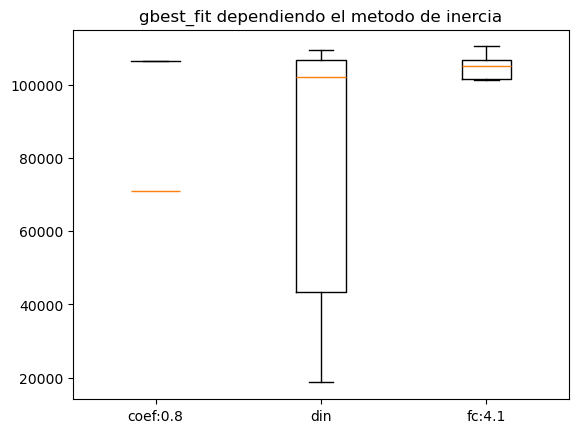

In [37]:
# inciso f

lanzadas = 20
resultados1 = []
w = 0.8
for i in range(lanzadas):
    resultados1.append(correr(n_particles, n_dimensions, max_iterations, c1, c2,'coef', w)[-1,-1])

resultados2 = []
for i in range(lanzadas):
    resultados2.append(correr(n_particles, n_dimensions, max_iterations, c1, c2, 'din')[-1,-1])

fi=4.1
resultados3 = []
for i in range(lanzadas):
    resultados3.append(correr(n_particles, n_dimensions, max_iterations, c1, c2, 'fc', fi=fi)[-1,-1])

plt.boxplot([resultados1, resultados2, resultados3], showfliers=False)
plt.xticks([1, 2, 3], [f'coef:{w}', 'din', f'fc:{fi}'])
plt.title('gbest_fit dependiendo el metodo de inercia')
plt.show()